In [3]:
from src import kernel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./src/kernel/data/test_data1.csv')

In [5]:
df.head()

,0,1
0,-3.620286,-2.358816
1,-0.132184,-3.247832
2,-2.912721,-1.521750
3,-5.144268,4.760700
4,-5.693922,-2.663462


In [149]:
kM = kernel.Mean(df,sigma='silverman')

In [147]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)
z = kM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
zz = z.reshape(xx.shape[0],-1)

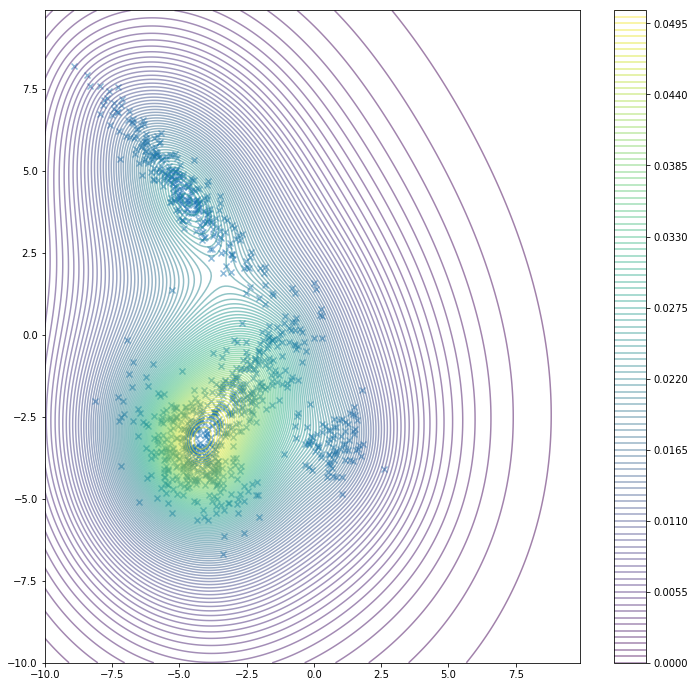

In [148]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111)
bar = ax.contour(xx,yy,zz,100,alpha=0.5)
ax.scatter(df.iloc[:,0],df.iloc[:,1],alpha=0.5,marker='x')
fig.colorbar(bar,ax=ax)
fig.show()

In [201]:
from src.kernel import Mean as kernelMean
from src.kernel.utils.progressbar import progbar
from src.kernel.utils.functions import gauss_kernel,get_band_width

import scipy as scp

class KernelHerding():
    def __init__(self, obj_KernelMean):
        if not isinstance(obj_KernelMean, kernelMean):
             raise TypeError(f"init object shuld be KernelMean class, but got {type(obj_KernelMean)}")

        self.KM = obj_KernelMean
        self.kernel = gauss_kernel(self.KM.sigma)
        
    def supersample(self, 
                    sample_size, 
                    x_initial_guess=None, 
                    options=None, 
                    verbose={'clear_display':True, 'display':'notebook'}):
        
        prob = progbar(sample_size, **verbose)
        h = self.KM.mu_p
        x1 = self._argmax(h, x_initial_guess, options)
        samples = np.array([x1])
        for idx in range(sample_size-1):
            h = self._herding_update(samples)
            x = self._argmax(h, x_initial_guess, options)
            samples = np.append(samples,np.array([x]),axis=0)
            prob.update(idx+1)
            
        self.samples = samples
        
        del prob
        return samples
    
    def _argmax(self, h, x_initial_guess=None, options=None):
        minus_h = lambda x: -1.*h(x)

        if options is None:
            options = {'optimizer':'scipy_optim','method':'Powell','options':None}
        if options['optimizer']=='scipy_optim':
            if x_initial_guess is None:
                x_initial_guess = np.zeros_like(KH.KM.x.loc[0])
            optimize_result = scp.optimize.minimize(minus_h, x_initial_guess, method=options['method'], options=options['options'])
            return optimize_result.x
        
    def _herding_update(self, samples):
        f = lambda x: self.KM.mu_p(x) - np.average(self.kernel(x,samples))
        return f
    
    def approximation_mean(self,x):
        #         , sigma='median'):
        #         if isinstance(sigma,str):
        #             sigma = get_band_width(self.samples, sigma)
        #         kernel = gauss_kernel(sigma)
        return np.average(self.kernel(x,self.samples),axis=1)

In [202]:
KH = KernelHerding(kM)

In [203]:
KH.supersample(100, 
               options={'optimizer':'scipy_optim','method':'Nelder-Mead','options':None})

'    100% |################################| 0day  0:00:00 Total time: 0day  0:00:10'

array([[-4.48258618e+00, -3.47414023e+00],
       [-2.67053267e+00, -1.68458828e+00],
       [-1.24216483e+00,  4.25994687e-02],
       [ 7.53466618e-01, -3.50491767e+00],
       [ 1.80464379e+00, -1.68591619e+00],
       [ 2.11528386e-01,  1.70769444e+00],
       [-1.08798130e+00, -1.61590492e+00],
       [ 4.05189703e+02,  9.58151555e+01],
       [-4.90870254e+00,  4.27707592e+00],
       [ 5.12934707e-01, -1.28596667e-01],
       [-3.96400699e+00,  3.50919682e+00],
       [-3.05441947e+00,  2.45459880e+00],
       [-1.81573309e+00,  1.54001521e+00],
       [-5.11792132e-01,  6.78890356e-01],
       [-4.33502685e+00, -2.71509127e+00],
       [-3.83845040e+00, -4.03792751e+00],
       [-3.46917661e+00, -2.66174044e+00],
       [-2.36102535e+00, -8.65863985e-01],
       [ 1.71912053e+00, -3.41409737e+00],
       [-2.22858293e-01, -3.26345145e+00],
       [ 7.54854050e-01, -2.52218437e+00],
       [-1.64607627e+00, -8.32912073e-01],
       [ 4.93194352e-02, -1.34732837e+00],
       [-5.

In [205]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)
z_kernelh = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
z = KH.KM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
zz_kernlh = z_kernelh.reshape(xx.shape[0],-1)
zz = z.reshape(xx.shape[0],-1)

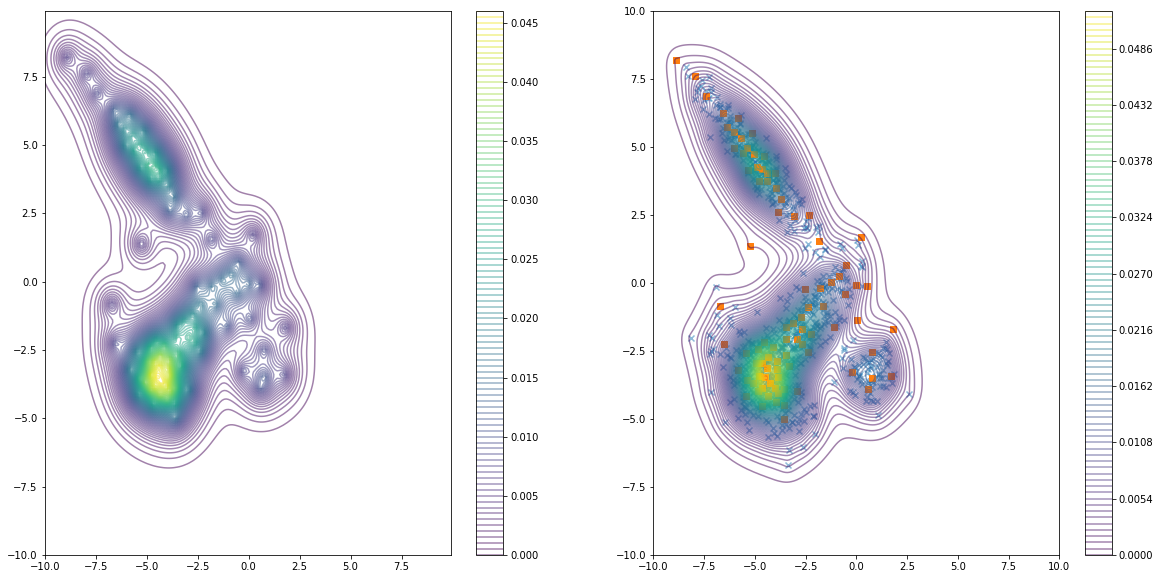

In [206]:
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(121)
cbar1 = ax1.contour(xx,yy,zz_kernlh,100,alpha=0.5)
ax.scatter(KH.samples[:,0],KH.samples[:,1],marker='s',color='r')
fig.colorbar(cbar1,ax=ax1)

ax2 = fig.add_subplot(122)
cbar2 = ax2.contour(xx,yy,zz,100,alpha=0.5)
ax2.scatter(df.iloc[:,0],df.iloc[:,1],alpha=0.5,marker='x')
ax2.scatter(KH.samples[:,0],KH.samples[:,1],marker='s')
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
fig.colorbar(cbar2,ax=ax2)

fig.show()